In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
cwd = os.getcwd().replace("/note/experiments", "")
os.chdir(cwd)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xtools as xt
import json
import xsim
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from collections import namedtuple


In [4]:
from qml.db import dpo as xdpo
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator
from qml.model.gate import Gateset
from qml.model.unit import UnitManager, Unit
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model
from qml.optimizer import dpo as xdpopt
from qml.optimizer import evaluator as xeval
from qml.tools.random import XRandomGenerator
from qml.tools.sampler import CandidateSampler
from qml import optimizer as xoptim
from qml.tools.config import Config
# from qml.tools.validation import validate
from qml.tools.experiment_tools import train_once, hard_copy, prepare_policy, plot_results, validate

In [5]:
cf = Config("note/experiments/config.yaml")

In [6]:
cf.shots

30

In [7]:
def plot_results_on_notebook(logger, vlogger, cf):
    ret = xsim.Retriever(logger)
    res_dict = dict(
        epoch=ret.epoch(),
        loss=ret.loss(),
        loss_dpo=ret.loss_dpo(),
    )
    plot_labels = ["loss_dpo"]
    if cf.dpo.training.cpo:
        res_dict["loss_llh"] = ret.loss_llh()
        plot_labels.append("loss_llh")
    plot_labels.append("loss")
    res = pd.DataFrame(res_dict)

    vret = xsim.Retriever(vlogger)
    vres = pd.DataFrame(dict(
        epoch=vret.epoch(),
        loss=vret.loss(),
        time=vret.time(),
    ))

    clear_output()
    fig, axes = plt.subplots(nrows=3, figsize=(8, 10), sharex=True)
    res.plot(x="epoch", y=plot_labels, ax=axes[0])
    vres.plot(x="epoch", y=["loss"], ax=axes[1])
    vres.plot(x="epoch", y=["time"], ax=axes[2])
    plt.show()

    return res, vres


In [8]:
# training dataset
dataset = xdpo.DPODataset(cf.dpo.training.db.filename, cf.nq, cf.ocg.dim_wavelet)
loader = xdpo.DPODataLoader(dataset, cf.nq, cf.dpo.training.db.batch_size, cf.ocg.dim_wavelet)


In [9]:
# validation datasets
tfun = xtarget.PolynominalTargetFunctionGenerator(cf.qml.db.dim_polynomial)
tgen = MLDatasetGenerator(tfun)
validation_datasets = [
    tgen.generate(cf.dpo.validation.dbsize)
    for _ in range(cf.dpo.validation.num_db)
]

In [10]:
save_dir = xt.make_dirs_current_time("note/experiments/results")

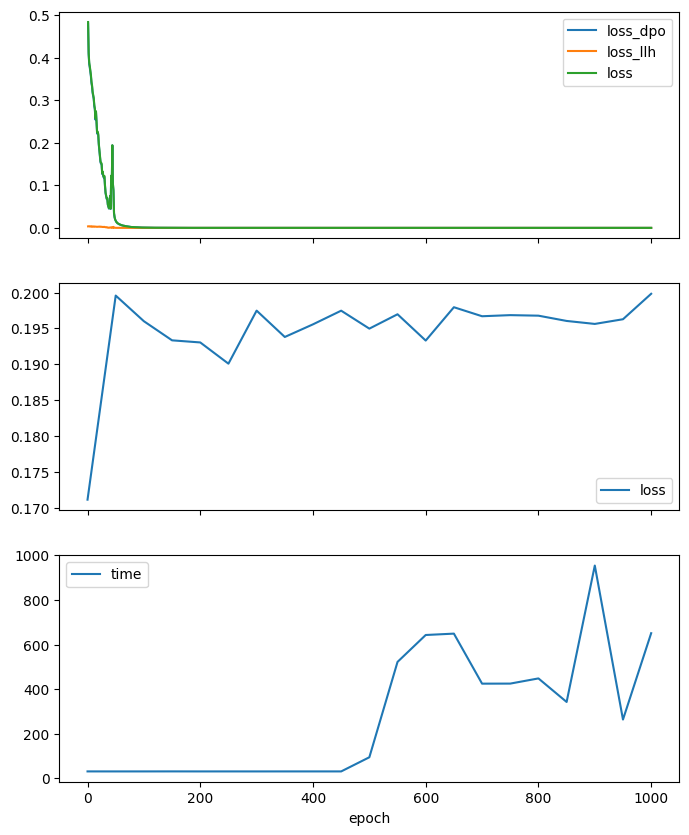

In [ ]:
save_dir = xt.make_dirs_current_time("note/experiments/results")

policy, reference, optimizer, sampler = prepare_policy(cf)
logger = xsim.Logger()
vlogger = xsim.Logger()


torch.save(policy.state_dict(), xt.join(save_dir, f"results_0000.pth"))
vresults = validate(sampler, validation_datasets, cf)
vlogger.store(
    epoch=0,
    **vresults,
).flush()

for epoch in range(1, cf.dpo.training.num_epochs+1):
    epoch_losses = []
    # hard_copy(policy, reference)
    for batch in loader:
        losses = train_once(policy, reference, optimizer, batch, sampler, cf)
        
        # logging
        epoch_losses.append(losses)

    loss = np.mean([loss.total for loss in epoch_losses])
    loss_dpo = np.mean([loss.dpo for loss in epoch_losses])
    logger.store(
        epoch=epoch,
        loss=loss,
        loss_dpo=loss_dpo,
    )
    status = f"epoch {epoch:>3}  loss: {loss:.4f}  dpo: {loss_dpo:.4f}"

    if cf.dpo.training.cpo:
        loss_llh = np.mean([loss.llh for loss in epoch_losses])
        logger.store(loss_llh=loss_llh)
        status +=f"  llh: {loss_llh:.4f}"

    logger.flush()
    print(status)

    if epoch % cf.dpo.validation.interval == 0:
        torch.save(policy.state_dict(), xt.join(save_dir, f"results_{epoch:04d}.pth"))
        vresults = validate(sampler, validation_datasets, cf)
        vlogger.store(
            epoch=epoch,
            **vresults,
        ).flush()

        plot_results_on_notebook(logger, vlogger, cf)


res, vres = plot_results_on_notebook(logger, vlogger, cf)
res.to_csv(xt.join(save_dir, "results.csv"))
vres.to_csv(xt.join(save_dir, "vresults.csv"))
